In [78]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from time import time

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [79]:
class ARMA:
    def __init__(self, data, order, test_size):
        self.order = order
        self.ar_ord, self.ma_ord = order
        self.num_of_params = 1+self.ar_ord+self.ma_ord
        data = np.array(data)
        self.test_index = int(data.shape[0]*(1-test_size))
        self.train, self.test = data[:self.test_index], data[self.test_index:]
    
    @staticmethod
    def RSS(W_arma, start_shocks, ar_ord, ma_ord, data, ret_pred_shocks=False):
        shocks = np.hstack((0, start_shocks))
        rss = 0
        if ret_pred_shocks:
            first_shocks = np.append(np.zeros((ar_ord-ma_ord if ar_ord-ma_ord > 0 else 0)), start_shocks[ma_ord-ar_ord if ma_ord-ar_ord>0 else 0:])
            pred_to_ret = np.append(data[:ar_ord]-first_shocks, np.zeros((data.shape[0]-ar_ord)))
            shocks_to_ret = np.append(first_shocks, np.zeros((data.shape[0]-ar_ord)))
        #-----loop-start---
        arma_in = np.hstack((1, data[ar_ord-1:None if ar_ord else -1:-1], shocks[-1:-ma_ord-1:-1]))
        pred = np.dot(arma_in, W_arma)
        shocks = np.append(shocks[1:], data[ar_ord]-pred)
        if ret_pred_shocks:
            pred_to_ret[ar_ord] = pred
            shocks_to_ret[ar_ord] = shocks[-1]
        try:
            rss += shocks[-1]**2
        except FloatingPointError:
            return np.inf
        for i in range(ar_ord+1, data.shape[0]):
            arma_in = np.hstack((1, data[i-1:i-ar_ord-1:-1], shocks[-1:-ma_ord-1:-1]))
            pred = np.dot(arma_in, W_arma)
            shocks = np.append(shocks[1:], data[i]-pred)
            if ret_pred_shocks:
                pred_to_ret[i] = pred
                shocks_to_ret[i] = shocks[-1]
            try:
                rss += shocks[-1]**2
            except FloatingPointError:
                return np.inf
        #------------
        if ret_pred_shocks: return pred_to_ret, shocks_to_ret
        return 0.5*(rss)
    
    def RSS_to_opt(params, ar_ord, ma_ord, data, exact):
        if exact:
            W_arma = params[:ar_ord+ma_ord+1]
            start_shocks = params[ar_ord+ma_ord+1:]
        else:
            W_arma = params
            start_shocks = np.zeros((ma_ord))
        return ARMA.RSS(W_arma, start_shocks, ar_ord, ma_ord, data)
    
    def backprop(): pass
    
    def optres_unpack(params, ar_ord, ma_ord, exact):
        if exact:
            W_arma = params[:ar_ord+ma_ord+1]
            start_shocks = params[ar_ord+ma_ord+1:]
        else:
            W_arma = params
            start_shocks = np.zeros((ma_ord))
        return W_arma, start_shocks
    
    def fit(self, rand_steps=3, solver="l-bfgs-b", maxiter=500, maxfun=15000, tol=1e-4, iprint=0, exact=True):
        #--optimization---
        rss_min, count, best_optres = np.inf, 0, None
        while count < rand_steps:
            try:
                if exact:
                    init = np.random.normal(size=self.num_of_params+self.ma_ord)
                    optres = optimize.minimize(ARMA.RSS_to_opt, init, (self.ar_ord, self.ma_ord, self.train, exact), method=solver, options={"gtol":tol, "maxfun":maxfun, "maxiter":maxiter, "iprint":iprint})
                else:
                    init = np.random.normal(size=self.num_of_params)
                    optres = optimize.minimize(ARMA.RSS_to_opt, init, (self.ar_ord, self.ma_ord, self.train, exact), method=solver, options={"gtol":tol, "maxfun":maxfun, "maxiter":maxiter, "iprint":iprint})
            except FloatingPointError:
                print("Error on init:{}".format(init))
                continue
            if optres.fun == np.inf: 
                print("Diverge on init:{}".format(init))
                continue
            count+=1
            if optres.fun < rss_min:
                rss_min = optres.fun
                best_optres = optres
                print("New best result:{}".format(best_optres.fun))
                print("on init:{}".format(init))
        #------------
        self.W_arma, self.start_shocks = ARMA.optres_unpack(best_optres.x, self.ar_ord, self.ma_ord, exact)
        self.pred, self.shocks = ARMA.RSS(self.W_arma, self.start_shocks, self.ar_ord, self.ma_ord, self.train, ret_pred_shocks=True)
        self.std_dev = np.sqrt(np.sum(np.square(self.shocks-np.mean(self.shocks)))/(self.shocks.shape[0]-1))
        self.loglik = -0.5*(self.train.shape[0]-self.ar_ord)*np.log(2*np.pi*self.std_dev**2)-best_optres.fun/self.std_dev**2
        self.aic = -2/self.train.shape[0]*(self.loglik-self.num_of_params)
        self.mse = np.sum(np.square(self.shocks[self.ar_ord:]))/self.train.shape[0]
        self.rmse = np.sqrt(self.mse)
        return self
        
    def predict(self, test=None):
        if test is None: test = self.test
        predicted = np.zeros((test.shape[0]))
        shocks = np.append(self.shocks, np.zeros((test.shape[0])))
        m = self.train.shape[0]
        data = np.append(self.train, test)
        for i in range(m, m+test.shape[0]):
            arma_in = np.hstack((1, data[i-1:i-self.ar_ord-1:-1], shocks[i-1:i-self.ma_ord-1:-1]))
            predicted[i-m] = np.dot(arma_in, self.W_arma)
            shocks[i] = test[i-m]-predicted[i-m]
        self.test_mse = np.sum(np.square(shocks[m:]))/data.shape[0]
        self.test_rmse = np.sqrt(self.test_mse)
        return predicted
    
    def forecast(self, n_pred): pass

In [80]:
class ARMA_with_backprop:
    def __init__(self, data, order, test_size):
        self.order = order
        self.ar_ord, self.ma_ord = order
        self.num_of_params = 1+self.ar_ord+self.ma_ord
        data = np.array(data)
        self.test_index = int(data.shape[0]*(1-test_size))
        self.train, self.test = data[:self.test_index], data[self.test_index:]
    
    def vect_on_scal(vect, scal):
        for i in range(vect.shape[0]):
            try:
                vect[i] = vect[i]*scal
            except FloatingPointError:
                vect[i] = np.sign(scal)*np.sign(vect[i])*np.inf
        return vect
    
    @staticmethod
    def RSS(W_arma, start_shocks, ar_ord, ma_ord, data, ret_pred_shocks=False):
        shocks = np.hstack((0, start_shocks))
        delta = 0
        rss = 0
        grad_W_arma = np.zeros((W_arma.shape[0]))
        if ret_pred_shocks:
            first_shocks = np.append(np.zeros((ar_ord-ma_ord if ar_ord-ma_ord > 0 else 0)), start_shocks[ma_ord-ar_ord if ma_ord-ar_ord>0 else 0:])
            pred_to_ret = np.append(data[:ar_ord]-first_shocks, np.zeros((data.shape[0]-ar_ord)))
            shocks_to_ret = np.append(first_shocks, np.zeros((data.shape[0]-ar_ord)))
        #-----loop-start---
        arma_in = np.hstack((1, data[ar_ord-1:None if ar_ord else -1:-1], shocks[-1:-ma_ord-1:-1]))
        pred = np.dot(arma_in, W_arma)
        shocks = np.append(shocks[1:], data[ar_ord]-pred)
        delta = -shocks[-1]
        grad_W_arma += ARMA_with_backprop.vect_on_scal(arma_in, delta)
        if ret_pred_shocks:
            pred_to_ret[ar_ord] = pred
            shocks_to_ret[ar_ord] = shocks[-1]
        try:
            rss += shocks[-1]**2
        except FloatingPointError:
            rss = np.inf
        
        for i in range(ar_ord+1, data.shape[0]):
            arma_in = np.hstack((1, data[i-1:i-ar_ord-1:-1], shocks[-1:-ma_ord-1:-1]))
            pred = np.dot(arma_in, W_arma)
            shocks = np.append(shocks[1:], data[i]-pred)
            delta = -shocks[-1]
            grad_W_arma += ARMA_with_backprop.vect_on_scal(arma_in, delta)
            if ret_pred_shocks:
                pred_to_ret[i] = pred
                shocks_to_ret[i] = shocks[-1]
            if rss != np.inf:
                try:
                    rss += shocks[-1]**2
                except FloatingPointError:
                    rss = np.inf
        #------------
        if ret_pred_shocks: return pred_to_ret, shocks_to_ret
        return 0.5*(rss), grad_W_arma
    
    def RSS_to_opt(params, ar_ord, ma_ord, data, exact):
        if exact:
            W_arma = params[:ar_ord+ma_ord+1]
            start_shocks = params[ar_ord+ma_ord+1:]
        else:
            W_arma = params
            start_shocks = np.zeros((ma_ord))
        if exact: return ARMA_with_backprop.RSS(W_arma, start_shocks, ar_ord, ma_ord, data)[0]
        return ARMA_with_backprop.RSS(W_arma, start_shocks, ar_ord, ma_ord, data)
    
    def optres_unpack(params, ar_ord, ma_ord, exact):
        if exact:
            W_arma = params[:ar_ord+ma_ord+1]
            start_shocks = params[ar_ord+ma_ord+1:]
        else:
            W_arma = params
            start_shocks = np.zeros((ma_ord))
        return W_arma, start_shocks
    
    def fit(self, rand_steps=3, solver="l-bfgs-b", maxiter=500, maxfun=15000, tol=1e-4, iprint=0, exact=True):
        tik = time()
        #--optimization---
        rss_min, count, best_optres = np.inf, 0, None
        while count < rand_steps:
            try:
                if exact:
                    init = np.random.normal(size=self.num_of_params+self.ma_ord)
                    optres = optimize.minimize(ARMA_with_backprop.RSS_to_opt, init, (self.ar_ord, self.ma_ord, self.train, exact), method=solver, jac=False, options={"gtol":tol, "maxfun":maxfun, "maxiter":maxiter, "iprint":iprint})
                else:
                    init = np.random.normal(size=self.num_of_params)
                    optres = optimize.minimize(ARMA_with_backprop.RSS_to_opt, init, (self.ar_ord, self.ma_ord, self.train, exact), method=solver, jac=True, options={"gtol":tol, "maxfun":maxfun, "maxiter":maxiter, "iprint":iprint})
            except FloatingPointError:
                print("Error on init:{}".format(init))
                continue
            if optres.fun == np.inf: 
                print("Diverge on init:{}".format(init))
                continue
            count+=1
            if optres.fun < rss_min:
                rss_min = optres.fun
                best_optres = optres
                print("New best result:{}".format(best_optres.fun))
                print("on init:{}".format(init))
        #------------
        print("fit-time:{}".format(time()-tik))
        self.W_arma, self.start_shocks = ARMA_with_backprop.optres_unpack(best_optres.x, self.ar_ord, self.ma_ord, exact)
        self.pred, self.shocks = ARMA_with_backprop.RSS(self.W_arma, self.start_shocks, self.ar_ord, self.ma_ord, self.train, ret_pred_shocks=True)
        self.std_dev = np.sqrt(np.sum(np.square(self.shocks-np.mean(self.shocks)))/(self.shocks.shape[0]-1))
        self.loglik = -0.5*(self.train.shape[0]-self.ar_ord)*np.log(2*np.pi*self.std_dev**2)-best_optres.fun/self.std_dev**2
        self.aic = -2/self.train.shape[0]*(self.loglik-self.num_of_params)
        self.mse = np.sum(np.square(self.shocks[self.ar_ord:]))/self.train.shape[0]
        self.rmse = np.sqrt(self.mse)
        return self
        
    def predict(self, test=None):
        if test is None: test = self.test
        predicted = np.zeros((test.shape[0]))
        shocks = np.append(self.shocks, np.zeros((test.shape[0])))
        m = self.train.shape[0]
        data = np.append(self.train, test)
        for i in range(m, m+test.shape[0]):
            arma_in = np.hstack((1, data[i-1:i-self.ar_ord-1:-1], shocks[i-1:i-self.ma_ord-1:-1]))
            predicted[i-m] = np.dot(arma_in, self.W_arma)
            shocks[i] = test[i-m]-predicted[i-m]
        self.test_mse = np.sum(np.square(shocks[m:]))/data.shape[0]
        self.test_rmse = np.sqrt(self.test_mse)
        return predicted
    
    def forecast(self, n_pred): pass

In [81]:
class NN:
    def __init__(self, data, order, test_size):
        self.order = order
        self.ar_ord, self.ma_ord, self.hid_size = order
        self.num_of_params = 1+(self.ar_ord+self.ma_ord+2)*self.hid_size
        data = np.array(data)
        self.test_index = int(data.shape[0]*(1-test_size))
        self.train, self.test = data[:self.test_index], data[self.test_index:]
    
    @staticmethod
    def F(vect, add=True):
        logistic = lambda z: 1/(1+np.exp(-z))
        for i in range(vect.shape[0]):
            try:
                vect[i] = logistic(vect[i])
            except FloatingPointError:
                if vect[i]>0: vect[i] = 1
                else: vect[i] = 0
        if add: return np.hstack((1, vect))
        return vect
    
    def derF(vect): return NN.F(vect, add=False)-NN.to_square(NN.F(vect, add=False))
    
    def to_square(vect):
        for i in range(vect.shape[0]):
            try:
                vect[i] = vect[i]**2
            except FloatingPointError:
                vect[i] = np.inf
        return vect
    
    @staticmethod
    def RSS(W1, W2, start_shocks, ar_ord, ma_ord, hid_size, data, ret_pred_shocks=False):
        shocks = np.hstack((0, start_shocks))
        rss = 0
        delta1, delta2 = np.zeros((hid_size)), 0
        grad_W1 = np.zeros((ar_ord+ma_ord+1, hid_size))
        grad_W2 = np.zeros((hid_size+1))
        if ret_pred_shocks:
            first_shocks = np.append(np.zeros((ar_ord-ma_ord if ar_ord-ma_ord > 0 else 0)), start_shocks[ma_ord-ar_ord if ma_ord-ar_ord>0 else 0:])
            pred_to_ret = np.append(data[:ar_ord]-first_shocks, np.zeros((data.shape[0]-ar_ord)))
            shocks_to_ret = np.append(first_shocks, np.zeros((data.shape[0]-ar_ord)))
        #-----loop-start---
        I = np.hstack((1, data[ar_ord-1:None if ar_ord else -1:-1], shocks[-1:-ma_ord-1:-1]))
        A1 = np.dot(I, W1)
        Z2 = NN.F(A1)
        pred = np.dot(Z2, W2)
        shocks = np.append(shocks[1:], data[ar_ord]-pred)
        delta2 = -shocks[-1]
        delta1 = NN.derF(A1)*W2[1:]*delta2
        grad_W1 += np.tensordot(I, delta1, axes=0)
        grad_W2 += Z2*delta2
        if ret_pred_shocks:
            pred_to_ret[ar_ord] = pred
            shocks_to_ret[ar_ord] = shocks[-1]
        try:
            rss += shocks[-1]**2
        except FloatingPointError:
            rss = np.inf
        for i in range(ar_ord+1, data.shape[0]):
            I = np.hstack((1, data[i-1:i-ar_ord-1:-1], shocks[-1:-ma_ord-1:-1]))
            A1 = np.dot(I, W1)
            Z2 = NN.F(A1)
            pred = np.dot(Z2, W2)
            shocks = np.append(shocks[1:], data[i]-pred)
            delta2 = -shocks[-1]
            delta1 = NN.derF(A1)*W2[1:]*delta2
            grad_W1 += np.tensordot(I, delta1, axes=0)
            grad_W2 += Z2*delta2
            if ret_pred_shocks:
                pred_to_ret[i] = pred
                shocks_to_ret[i] = shocks[-1]
            if rss != np.inf:
                try:
                    rss += shocks[-1]**2
                except FloatingPointError:
                    rss = np.inf
        #------------
        if ret_pred_shocks: return pred_to_ret, shocks_to_ret
        return 0.5*(rss), np.hstack((grad_W1.ravel(), grad_W2))
    
    def RSS_to_opt(params, ar_ord, ma_ord, hid_size, data, exact):
        W1 = params[:(ar_ord+ma_ord+1)*hid_size].reshape((ar_ord+ma_ord+1, hid_size))
        if exact:
            W2 = params[(ar_ord+ma_ord+1)*hid_size:(ar_ord+ma_ord+1)*hid_size+hid_size+1]
            start_shocks = params[(ar_ord+ma_ord+1)*hid_size+hid_size+1:]
        else:
            W2 = params[-hid_size-1:]
            start_shocks = np.zeros((ma_ord))
        if exact: return NN.RSS(W1, W2, start_shocks, ar_ord, ma_ord, hid_size, data)[0]
        return NN.RSS(W1, W2, start_shocks, ar_ord, ma_ord, hid_size, data)
    
    def optres_unpack(params, ar_ord, ma_ord, hid_size, exact):
        W1 = params[:(ar_ord+ma_ord+1)*hid_size].reshape((ar_ord+ma_ord+1, hid_size))
        if exact:
            W2 = params[(ar_ord+ma_ord+1)*hid_size:(ar_ord+ma_ord+1)*hid_size+hid_size+1]
            start_shocks = params[(ar_ord+ma_ord+1)*hid_size+hid_size+1:]
        else:
            W2 = params[-hid_size-1:]
            start_shocks = np.zeros((ma_ord))
        return W1, W2, start_shocks   
    
    def fit(self, rand_steps=3, solver="l-bfgs-b", maxiter=500, maxfun=15000, tol=1e-4, iprint=0, exact=True):
        tik = time()
        #--optimization---
        rss_min, count, best_optres = np.inf, 0, None
        while count < rand_steps:
            try:
                if exact:
                    init = np.random.normal(size=self.num_of_params+self.ma_ord)
                    optres = optimize.minimize(NN.RSS_to_opt, init, (self.ar_ord, self.ma_ord, self.hid_size, self.train, exact), method=solver, jac=False, options={"gtol":tol, "maxfun":maxfun, "maxiter":maxiter, "iprint":iprint})
                else:
                    init = np.random.normal(size=self.num_of_params)
                    optres = optimize.minimize(NN.RSS_to_opt, init, (self.ar_ord, self.ma_ord, self.hid_size, self.train, exact), method=solver, jac=True, options={"gtol":tol, "maxfun":maxfun, "maxiter":maxiter, "iprint":iprint})
            except FloatingPointError:
                print("Get Error on init:{}".format(init))
                continue
            if optres.fun == np.inf: 
                print("Diverge on init:{}".format(init))
                continue
            count+=1
            if optres.fun < rss_min:
                rss_min = optres.fun
                best_optres = optres
                print("New best result:{}".format(best_optres.fun))
                print("on init:{}".format(init))
        #------------
        print("fit-time:{}".format(time()-tik))
        self.W1, self.W2, self.start_shocks = NN.optres_unpack(best_optres.x, self.ar_ord, self.ma_ord, self.hid_size, exact)
        self.pred, self.shocks = NN.RSS(self.W1, self.W2, self.start_shocks, self.ar_ord, self.ma_ord, self.hid_size, self.train, ret_pred_shocks=True)
        self.std_dev = np.sqrt(np.sum(np.square(self.shocks-np.mean(self.shocks)))/(self.shocks.shape[0]-1))
        self.loglik = -0.5*(self.train.shape[0]-self.ar_ord)*np.log(2*np.pi*self.std_dev**2)-best_optres.fun/self.std_dev**2
        self.aic = -2/self.train.shape[0]*(self.loglik-self.num_of_params)
        self.mse = np.sum(np.square(self.shocks[self.ar_ord:]))/self.train.shape[0]
        self.rmse = np.sqrt(self.mse)
        return self                 

    
    def predict(self, test=None):
        if test is None: test = self.test
        predicted = np.zeros((test.shape[0]))
        shocks = np.append(self.shocks, np.zeros((test.shape[0])))
        m = self.train.shape[0]
        data = np.append(self.train, test)
        for i in range(m, m+test.shape[0]):
            I = np.hstack((1, data[i-1:i-self.ar_ord-1:-1], shocks[i-1:i-self.ma_ord-1:-1]))
            predicted[i-m] = np.dot(NN.F(np.dot(I, self.W1)), self.W2)
            shocks[i] = test[i-m]-predicted[i-m]
        self.test_mse = np.sum(np.square(shocks[m:]))/data.shape[0]
        self.test_rmse = np.sqrt(self.test_mse)
        return predicted
    
    def forecast(self, n_pred): pass

In [82]:
class ARMA_NN:
    def __init__(self, data, order, test_size):
        self.order = order
        self.ar_ord, self.ma_ord, self.nn_ar_ord, self.nn_ma_ord, self.nn_hid_size = order
        self.num_of_params = 1+self.ar_ord+self.ma_ord+(self.nn_ar_ord+self.nn_ma_ord+2)*self.nn_hid_size
        data = np.array(data)
        self.test_index = int(data.shape[0]*(1-test_size))
        self.train, self.test = data[:self.test_index], data[self.test_index:]
    
    @staticmethod
    def F(vect):
        logistic = lambda z: 1/(1+np.exp(-z))
        for i in range(vect.shape[0]):
            try:
                vect[i] = logistic(vect[i])
            except FloatingPointError:
                if vect[i]>0: vect[i] = 1
                else: vect[i] = 0
        return vect

    def derF(vect): return ARMA_NN.F(vect)-ARMA_NN.to_square(ARMA_NN.F(vect))
    
    def to_square(vect):
        for i in range(vect.shape[0]):
            try:
                vect[i] = vect[i]**2
            except FloatingPointError:
                vect[i] = np.inf
        return vect
    
    def RSS(W_arma, W1, W2, start_shocks, ar_ord, ma_ord, nn_ar_ord, nn_ma_ord, nn_hid_size, data, ret_pred_shocks=False):
        max_ar_ord, max_ma_ord = max(ar_ord, nn_ar_ord), max(ma_ord, nn_ma_ord)
        shocks = np.hstack((0, start_shocks))
        rss = 0
        delta1, delta2 = np.zeros((nn_hid_size)), 0
        grad_W_arma = np.zeros(1+ar_ord+ma_ord)
        grad_W1 = np.zeros((nn_ar_ord+nn_ma_ord+1, nn_hid_size))
        grad_W2 = np.zeros((nn_hid_size))
        if ret_pred_shocks:
            first_shocks = np.append(np.zeros((max_ar_ord-max_ma_ord if max_ar_ord-max_ma_ord > 0 else 0)), start_shocks[max_ma_ord-max_ar_ord if max_ma_ord-max_ar_ord>0 else 0:])
            pred_to_ret = np.append(data[:max_ar_ord]-first_shocks, np.zeros((data.shape[0]-max_ar_ord)))
            shocks_to_ret = np.append(first_shocks, np.zeros((data.shape[0]-max_ar_ord)))
        #-----loop-start---
        I_arma = np.hstack((1, data[max_ar_ord-1:None if max_ar_ord-ar_ord-1==-1 and max_ar_ord else max_ar_ord-ar_ord-1:-1], shocks[-1:-ma_ord-1:-1]))
        I = np.hstack((1, data[max_ar_ord-1:None if max_ar_ord-nn_ar_ord-1==-1 and max_ar_ord else max_ar_ord-nn_ar_ord-1:-1], shocks[-1:-nn_ma_ord-1:-1]))
        A1 = np.dot(I, W1)
        Z2 = ARMA_NN.F(A1)
        pred = np.dot(I_arma, W_arma) + np.dot(Z2, W2)
        shocks = np.append(shocks[1:], data[max_ar_ord]-pred)
        delta2 = -shocks[-1]
        delta1 = ARMA_NN.derF(A1)*W2*delta2
        grad_W_arma += I_arma*delta2
        grad_W1 += np.tensordot(I, delta1, axes=0)
        grad_W2 += Z2*delta2
        if ret_pred_shocks:
            pred_to_ret[max_ar_ord] = pred
            shocks_to_ret[max_ar_ord] = shocks[-1]
        try:
            rss += shocks[-1]**2
        except FloatingPointError:
            rss = np.inf
        for i in range(max_ar_ord+1, data.shape[0]):
            I_arma = np.hstack((1, data[i-1:i-ar_ord-1:-1], shocks[-1:-ma_ord-1:-1]))
            I = np.hstack((1, data[i-1:i-nn_ar_ord-1:-1], shocks[-1:-nn_ma_ord-1:-1]))
            A1 = np.dot(I, W1)
            Z2 = ARMA_NN.F(A1)
            pred = np.dot(I_arma, W_arma) + np.dot(Z2, W2)
            shocks = np.append(shocks[1:], data[i]-pred)
            delta2 = -shocks[-1]
            delta1 = ARMA_NN.derF(A1)*W2*delta2
            grad_W_arma += I_arma*delta2
            grad_W1 += np.tensordot(I, delta1, axes=0)
            grad_W2 += Z2*delta2
            if ret_pred_shocks:
                pred_to_ret[i] = pred
                shocks_to_ret[i] = shocks[-1]
            if rss != np.inf:
                try:
                    rss += shocks[-1]**2
                except FloatingPointError:
                    rss = np.inf
        #------------
        if ret_pred_shocks: return pred_to_ret, shocks_to_ret
        return 0.5*(rss), np.hstack((grad_W_arma, grad_W1.ravel(), grad_W2))
    
    def RSS_to_opt(params, ar_ord, ma_ord, nn_ar_ord, nn_ma_ord, nn_hid_size, data, exact):
        W_arma = params[:1+ar_ord+ma_ord]
        W1 = params[1+ar_ord+ma_ord:1+ar_ord+ma_ord+(nn_ar_ord+nn_ma_ord+1)*nn_hid_size].reshape((nn_ar_ord+nn_ma_ord+1, nn_hid_size))
        if exact:
            W2 = params[1+ar_ord+ma_ord+(nn_ar_ord+nn_ma_ord+1)*nn_hid_size:1+ar_ord+ma_ord+(1+nn_ar_ord+nn_ma_ord)*nn_hid_size+nn_hid_size]
            start_shocks = params[1+ar_ord+ma_ord+(1+nn_ar_ord+nn_ma_ord)*nn_hid_size+nn_hid_size:]
        else:
            W2 = params[-nn_hid_size:]
            start_shocks = np.zeros((max(ma_ord, nn_ma_ord)))
        if exact: return ARMA_NN.RSS(W_arma, W1, W2, start_shocks, ar_ord, ma_ord, nn_ar_ord, nn_ma_ord, nn_hid_size, data)[0]
        return ARMA_NN.RSS(W_arma, W1, W2, start_shocks, ar_ord, ma_ord, nn_ar_ord, nn_ma_ord, nn_hid_size, data)

    def optres_unpack(params, ar_ord, ma_ord, nn_ar_ord, nn_ma_ord, nn_hid_size, exact):
        W_arma = params[:1+ar_ord+ma_ord]
        W1 = params[1+ar_ord+ma_ord:1+ar_ord+ma_ord+(1+nn_ar_ord+nn_ma_ord)*nn_hid_size].reshape((nn_ar_ord+nn_ma_ord+1, nn_hid_size))
        if exact:
            W2 = params[1+ar_ord+ma_ord+(1+nn_ar_ord+nn_ma_ord)*nn_hid_size:1+ar_ord+ma_ord+(1+nn_ar_ord+nn_ma_ord)*nn_hid_size+nn_hid_size]
            start_shocks = params[1+ar_ord+ma_ord+(1+nn_ar_ord+nn_ma_ord)*nn_hid_size+nn_hid_size:]
        else:
            W2 = params[-nn_hid_size:]
            start_shocks = np.zeros((max(ma_ord, nn_ma_ord)))
        return W_arma, W1, W2, start_shocks   

    def fit(self, rand_steps=3, solver="l-bfgs-b", maxiter=500, maxfun=15000, tol=1e-4, iprint=0, exact=True):
        tik = time()
        #--optimization---
        rss_min, count, best_optres = np.inf, 0, None
        while count < rand_steps:
            try:
                if exact:
                    init = np.random.normal(size=self.num_of_params+max(self.ma_ord, self.nn_ma_ord))
                    optres = optimize.minimize(ARMA_NN.RSS_to_opt, init, (self.ar_ord, self.ma_ord, self.nn_ar_ord, self.nn_ma_ord, self.nn_hid_size, self.train, exact), method=solver, jac=False, options={"gtol":tol, "maxfun":maxfun, "maxiter":maxiter, "iprint":iprint})
                else:
                    init = np.random.normal(size=self.num_of_params)
                    optres = optimize.minimize(ARMA_NN.RSS_to_opt, init, (self.ar_ord, self.ma_ord, self.nn_ar_ord, self.nn_ma_ord, self.nn_hid_size, self.train, exact), method=solver, jac=True, options={"gtol":tol, "maxfun":maxfun, "maxiter":maxiter, "iprint":iprint})           
            except FloatingPointError:
                print("Get Error on init:{}".format(init))
                continue
            if optres.fun == np.inf: 
                print("Diverge on init:{}".format(init))
                continue
            count+=1
            if optres.fun < rss_min:
                rss_min = optres.fun
                best_optres = optres
                print("New best result:{}".format(best_optres.fun))
                print("on init:{}".format(init))
        #------------
        print("fit-time:{}".format(time()-tik))
        self.W_arma, self.W1, self.W2, self.start_shocks = ARMA_NN.optres_unpack(best_optres.x, self.ar_ord, self.ma_ord, self.nn_ar_ord, self.nn_ma_ord, self.nn_hid_size, exact)
        self.pred, self.shocks = ARMA_NN.RSS(self.W_arma, self.W1, self.W2, self.start_shocks, self.ar_ord, self.ma_ord, self.nn_ar_ord, self.nn_ma_ord, self.nn_hid_size, self.train, ret_pred_shocks=True)
        self.std_dev = np.sqrt(np.sum(np.square(self.shocks-np.mean(self.shocks)))/(self.shocks.shape[0]-1))
        self.loglik = -0.5*(self.train.shape[0]-max(self.ar_ord, self.nn_ar_ord))*np.log(2*np.pi*self.std_dev**2)-best_optres.fun/self.std_dev**2
        self.aic = -2/self.train.shape[0]*(self.loglik-self.num_of_params)
        self.mse = np.sum(np.square(self.shocks[self.ar_ord:]))/self.train.shape[0]
        self.rmse = np.sqrt(self.mse)
        return self 

    def predict(self, test=None):
        if test is None: test = self.test
        predicted = np.zeros((test.shape[0]))
        shocks = np.append(self.shocks, np.zeros((test.shape[0])))
        m = self.train.shape[0]
        data = np.append(self.train, test)
        for i in range(m, m+test.shape[0]):
            I_arma = np.hstack((1, data[i-1:i-self.ar_ord-1:-1], shocks[i-1:i-self.ma_ord-1:-1]))
            I = np.hstack((1, data[i-1:i-self.nn_ar_ord-1:-1], shocks[i-1:i-self.nn_ma_ord-1:-1]))
            predicted[i-m] = np.dot(I_arma, self.W_arma) + np.dot(ARMA_NN.F(np.dot(I, self.W1)), self.W2)
            shocks[i] = test[i-m]-predicted[i-m]
        self.test_mse = np.sum(np.square(shocks[m:]))/data.shape[0]
        self.test_rmse = np.sqrt(self.test_mse)
        return predicted
    
    def forecast(self, n_pred): pass

In [83]:
def inv_diff(data, diff_data, diff_ord=1):
    if not diff_ord: return diff_data
    act_diff_data = np.diff(data, n=diff_ord-1)
    return inv_diff(data, np.append(act_diff_data[0], act_diff_data[:-1]+diff_data), diff_ord-1)

In [84]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [85]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.sum(np.square(y_true-y_pred)))

In [86]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh', max_lag=10):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        dful_pvalue = np.around(smt.stattools.adfuller(y)[1], 3)
        ACF = smt.stattools.acf(y, nlags=max_lag, qstat=True)
        ARord = np.array([i for i in range(0, max_lag+1) if abs(ACF[0][i])>2/np.sqrt(y.shape[0])])
        PACF = smt.stattools.pacf(y, nlags=max_lag)
        MAord = np.array([i for i in range(0, max_lag+1) if abs(PACF[i])>2/np.sqrt(y.shape[0])])
        Qstat_pvalue = np.around(ACF[2][max_lag-1], 3)
        jb_pvalue = sm.stats.stattools.jarque_bera(y)
        jb_pvalue, kurtosis = np.around(jb_pvalue[1], 3), np.around(jb_pvalue[3], 3)

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots\nDickey-Fuller Test: {}'.format(dful_pvalue))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        qq_ax.set_title('QQ Plot\nJarque-Bera Test: {}\nKurtosis: {}'.format(jb_pvalue, kurtosis))
        acf_ax.set_title("Autocorrelation\nQ({}): {}\nLast Singf Lag: {}".format(max_lag, Qstat_pvalue, max(ARord)))
        pacf_ax.set_title("Partial Autocorrelation\nLast Singf Lag: {}".format(max(MAord)))

        plt.tight_layout()
    plt.show()
    return ARord, MAord

In [87]:
def plotResult(data, mdl, test_index=0, ind1=0, ind2=None, diff_ord=1, stattools=False):
    data = np.array(data)
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
    if not stattools: pred = inv_diff(data, np.append(mdl.pred, mdl.predict()), diff_ord)
    else: pred = inv_diff(data, mdl.fittedvalues, diff_ord)
    ax1.plot(pred[ind1:ind2], label = "Model")
    ax1.plot(data[ind1:ind2], label = "Actual")
    error = mean_absolute_percentage_error(data[ind1:ind2], pred[ind1:ind2])
    ax1.set_title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    if not (ind1 or ind2): ax1.axvspan(len(data)-len(data[test_index:]), len(data), alpha=0.3, color='lightgrey')
    ax1.grid(True)
    ax1.axis('tight')
    ax1.legend(loc="best", fontsize=13);
    
    ax2.plot(pred[test_index:], label = "Model")
    ax2.plot(data[test_index:], label = "Actual")
    error = mean_absolute_percentage_error(data[test_index:], pred[test_index:])
    ax2.set_title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    ax2.grid(True)
    ax2.axis('tight')
    ax2.legend(loc="best", fontsize=13);
    plt.show()

In [106]:
def ResultTable(data, MODELS, test_index=0, index=None, diff_ord=1):
    data = np.array(data)
    RES = pd.DataFrame(index=index)
    rmse_vals = np.zeros((len(MODELS)))
    loglik_vals = np.zeros((len(MODELS)))
    mape_vals = np.zeros((len(MODELS)))
    for i in range(len(MODELS)):
        pred = inv_diff(data, np.append(MODELS[i].pred, MODELS[i].predict()), diff_ord)
        rmse_vals[i] = root_mean_squared_error(data[test_index:], pred[test_index:])
        mape_vals[i] = mean_absolute_percentage_error(data[test_index:], pred[test_index:])
        loglik_vals[i] = MODELS[i].loglik
    RES["rmse"] = rmse_vals
    RES["mape"] = mape_vals
    RES["loglik"] = loglik_vals
    return RES

In [89]:
AMZN = pd.read_csv(r"d:\LEARN\NGU\2kProga\AMZN.csv")
AMZN.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-05-15,298.019989,299.200012,290.380005,295.190002,295.190002,4295100
1,2014-05-16,292.799988,298.880005,291.549988,297.700012,297.700012,3636800
2,2014-05-19,295.760010,299.000000,293.809998,296.760010,296.760010,2284200
3,2014-05-20,297.100006,304.459991,296.750000,301.190002,301.190002,4095700
4,2014-05-21,302.209991,305.959991,301.519989,305.010010,305.010010,3408800


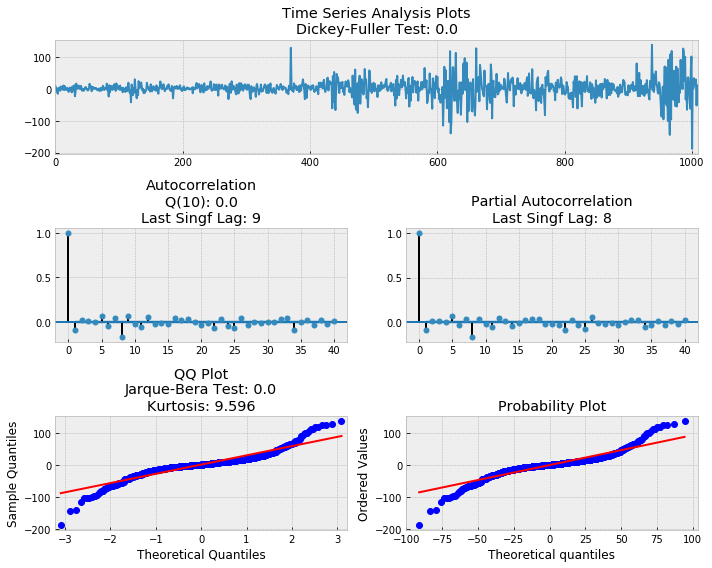

(array([0, 1, 5, 8, 9]), array([0, 1, 5, 8]))

In [91]:
amzn_close = np.array(AMZN.Close[500:])
amzn_close_diff = np.diff(amzn_close)
test_size = 30/amzn_close_diff.shape[0]
test_index = int(amzn_close_diff.shape[0]*(1-30/amzn_close_diff.shape[0]))
tsplot(amzn_close_diff, lags=40)

In [92]:
mdl1 = ARMA_with_backprop(amzn_close_diff, (1, 1), test_size).fit(exact=False)

D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in add
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


New best result:361613.1671661517
on init:[ 0.0160689  -1.30857171  0.34594725]
New best result:361611.78490866063
on init:[ 1.01262852 -0.06673588 -0.21743094]
fit-time:3.8572206497192383


In [93]:
mdl2 = NN(amzn_close_diff, (1, 1, 3), test_size).fit(exact=False)

New best result:364207.36877809395
on init:[-0.24558831 -0.41670463  2.13432467 -0.44013475 -0.32377841  1.16101418
 -0.07353402 -2.87603207 -0.12122102  1.51715339  0.00317053  1.47149347
  0.64135286]
New best result:364167.5381353364
on init:[-0.33150988 -2.09967    -2.76395585  0.55630394  1.22309916 -0.8602891
 -1.67939546 -0.80328699 -1.31132882  0.80083633  2.97680457 -1.43602364
  1.41221066]
New best result:364106.84636573034
on init:[ 1.72958313  0.37309307 -0.24316004  0.37588279 -1.08372426 -0.75440621
 -0.3741072   0.20729725  0.1395358  -0.00331989 -0.40139244 -1.33286761
  0.00555909]
fit-time:21.010201454162598


In [94]:
mdl3 = ARMA_NN(amzn_close_diff, (1, 1, 1, 1, 3), test_size).fit(exact=False)

D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in multiply
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: overflow encountered in double_scalars
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in multiply
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in add
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in multiply


New best result:366896.31466931215
on init:[-0.34270857 -0.00335216 -0.72136054  0.47537072 -1.80840905  0.25287641
  0.22071121  0.51967062  0.19767096  1.44921701  1.89175055  0.29299575
 -0.14255324 -1.51092643 -1.48291552]


D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


New best result:360669.7280093638
on init:[-1.90983874 -1.11724018 -0.81277981 -1.89906387 -0.16802942  0.08209295
 -0.59931811 -2.40368886  2.4778785  -1.98703264 -0.7910204  -0.10205349
  0.61984989  0.20564882  0.86820305]
fit-time:9.459541082382202


In [37]:
mdl3 = smt.statespace.SARIMAX(amzn_close, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)).fit()

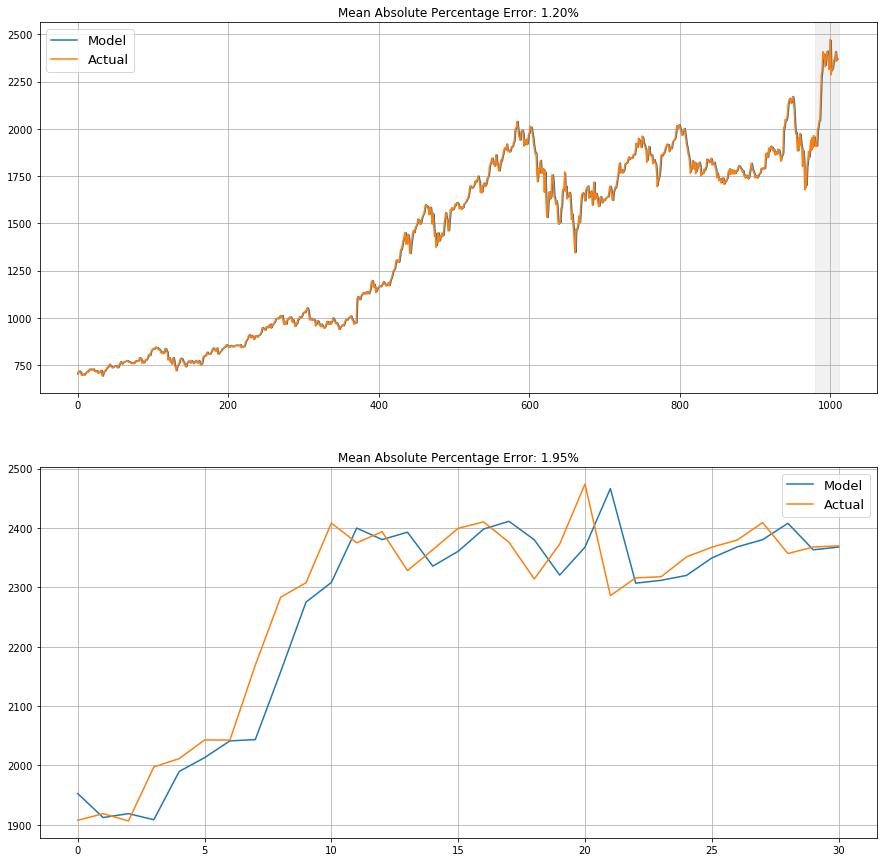

In [110]:
plotResult(amzn_close, mdl3, test_index=mdl2.test_index)

In [109]:
ResultTable(amzn_close, [mdl1, mdl2, mdl3], test_index=mdl2.test_index, index=[mdl1.order, mdl2.order, mdl3.order])

,rmse,mape,loglik
"(1, 1)",343.866938,1.950661,-4622.259951
"(1, 1, 3)",344.940177,1.963055,-4625.625821
"(1, 1, 1, 1, 3)",344.244233,1.951135,-4620.983060


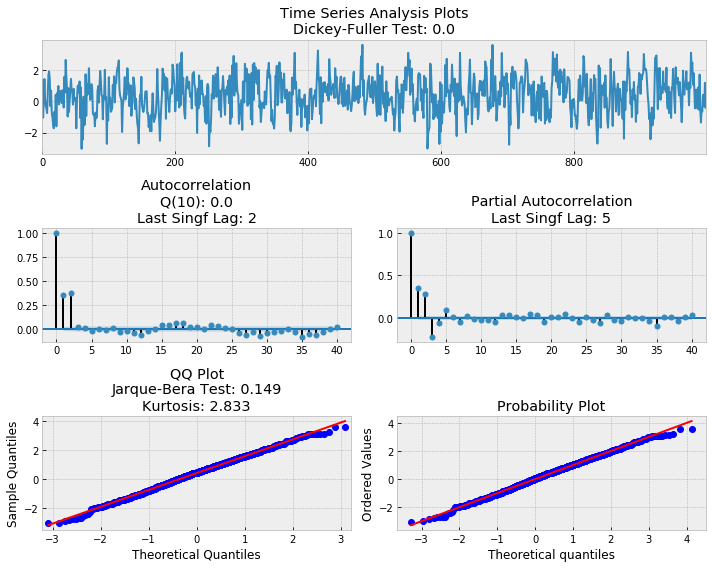

(array([0, 1, 2]), array([0, 1, 2, 3, 5]))

In [68]:
W_ARMA = np.array([0.33, 0.1, 0.07, 0.2, 0.4])
data = np.array([0, 0, 0])
shocks = np.array([0, 0, 0])
for i in range(10000):
    I_ARMA = np.hstack((1, data[-1:-3:-1], shocks[-1:-3:-1]))
    shock = np.random.normal()
    data = np.append(data, np.dot(I_ARMA, W_ARMA)+shock)
    shocks = np.append(shocks, shock)
data, shocks = data[-1000:], shocks[-1000:]
tsplot(data, lags=40)

In [70]:
mdl1 = ARMA(data, (2, 2), 0).fit()
mdl2 = smt.ARMA(data, (2, 2)).fit(method="mle")
mdl3 = smt.statespace.SARIMAX(data, order=(2, 0, 2), seasonal_order=(0, 0, 0, 0)).fit()
mdl4 = ARMA(data, (2, 2), 0).fit(exact=False)

New best result:499.9440096325085
on init:[-2.79903743 -0.32626981 -0.46993139  0.08075115 -0.00754479  0.4011295
 -0.69733052]


D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in double_scalars
D:\ProgramFiles\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


New best result:500.9021853869317
on init:[ 0.16068646  0.60366079 -0.6713647   0.93543126  0.51017425]


TypeError: _lbfgsb.setulb() 9th argument (pgtol) can't be converted to double

In [95]:
mdl5 = ARMA_with_backprop(data, (2, 2), 0).fit(exact=False, tol=1e-8)

D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in double_scalars
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in add


New best result:2511.723108650826
on init:[-0.1394042  -1.69902317  0.52492075  0.9057847  -0.13513824]
New best result:500.9751985316729
on init:[ 0.25540746  2.05785253  0.67274732  1.08994141  0.87202681]


In [102]:
mdl1.W_arma, mdl2.W_arma, mdl3.W_arma, mdl4.W_arma, mdl5.W_arma

(array([ 0.39169237,  0.02662234,  0.05805739,  0.28775858,  0.41933556]),
 array([ 0.39440741,  0.03939162,  0.04310424,  0.27508799,  0.42730411]),
 array([ 0.40365811,  0.03818266,  0.0385382 ,  0.27745356,  0.43287128]),
 array([ 0.39440693,  0.0393885 ,  0.04310901,  0.27509272,  0.42729862]),
 array([ 0.40299527,  0.03365142,  0.02876337,  0.27980238,  0.44550943]))